# NLS Normalization

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import os

# 1. Choose and Read

In [72]:
excel_path = "20241203_SX19C_bot_Heated_output.xlsx"

# Sheet 1: deltaP（沿用 df）
# Sheet 2: Pr（读成 df_Pr，index/列与 deltaP 相同的存储格式）
if excel_path and excel_path.endswith('.csv'):
    df = pd.read_csv(excel_path)
    df_Pr = None
else:
    df = pd.read_excel(excel_path, sheet_name=0)
    df_Pr = pd.read_excel(excel_path, sheet_name=1)

print(f"data shape: {df.shape}")
print(f"\n column names: {list(df.columns)}")
print(f"\n data preview:")
df.head(10)

VOLTAGE_COL = 'applied_E'        # 'voltage', 'Voltage (V)', 'V', etc.
PULSE_WIDTH_COL = 'pulse_width'  # 'pulse_width', 'hold_time', 't (s)', etc.
DELTA_P_COL = 'delta_P'         # 'delta_P', 'polarization', 'ΔP', etc.

# --- 限定用于作图/计算的电场(电压)范围 ---
E_MIN, E_MAX = 0.7, 2.0

def _parse_E_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str).str.strip().str.replace('V', '', regex=False),
        errors='coerce'
    )

E_num = _parse_E_numeric(df[VOLTAGE_COL])
df_range = df.loc[E_num.between(E_MIN, E_MAX, inclusive='both')].reset_index(drop=True)

if df_Pr is not None:
    E_num_Pr = _parse_E_numeric(df_Pr[VOLTAGE_COL])
    df_Pr_range = df_Pr.loc[E_num_Pr.between(E_MIN, E_MAX, inclusive='both')].reset_index(drop=True)
else:
    df_Pr_range = None

print(f"\nE range filter: [{E_MIN}, {E_MAX}] V -> {len(df_range)}/{len(df)} rows")

data shape: (17, 40)

 column names: ['applied_E', 3e-08, 4e-08, 5e-08, 6.000000000000001e-08, 7e-08, 9.000000000000001e-08, 1e-07, 1.778e-07, 3.162e-07, 5.623e-07, 1e-06, 1.8e-06, 3.2e-06, 5.6e-06, 9.999999999999999e-06, 1.78e-05, 3.16e-05, 5.62e-05, 9.999999999999999e-05, 0.0001778, 0.0003162, 0.0005623, 0.001, 0.0018, 0.0032, 0.0056, 0.01, 0.0178, 0.0316, 0.05620000000000001, 0.1, 0.1778, 0.3162, 0.5622999999999999, 1, '1.1', 3, 5, 10]

 data preview:

E range filter: [0.7, 2.0] V -> 11/17 rows


# PLot delta P vs. width

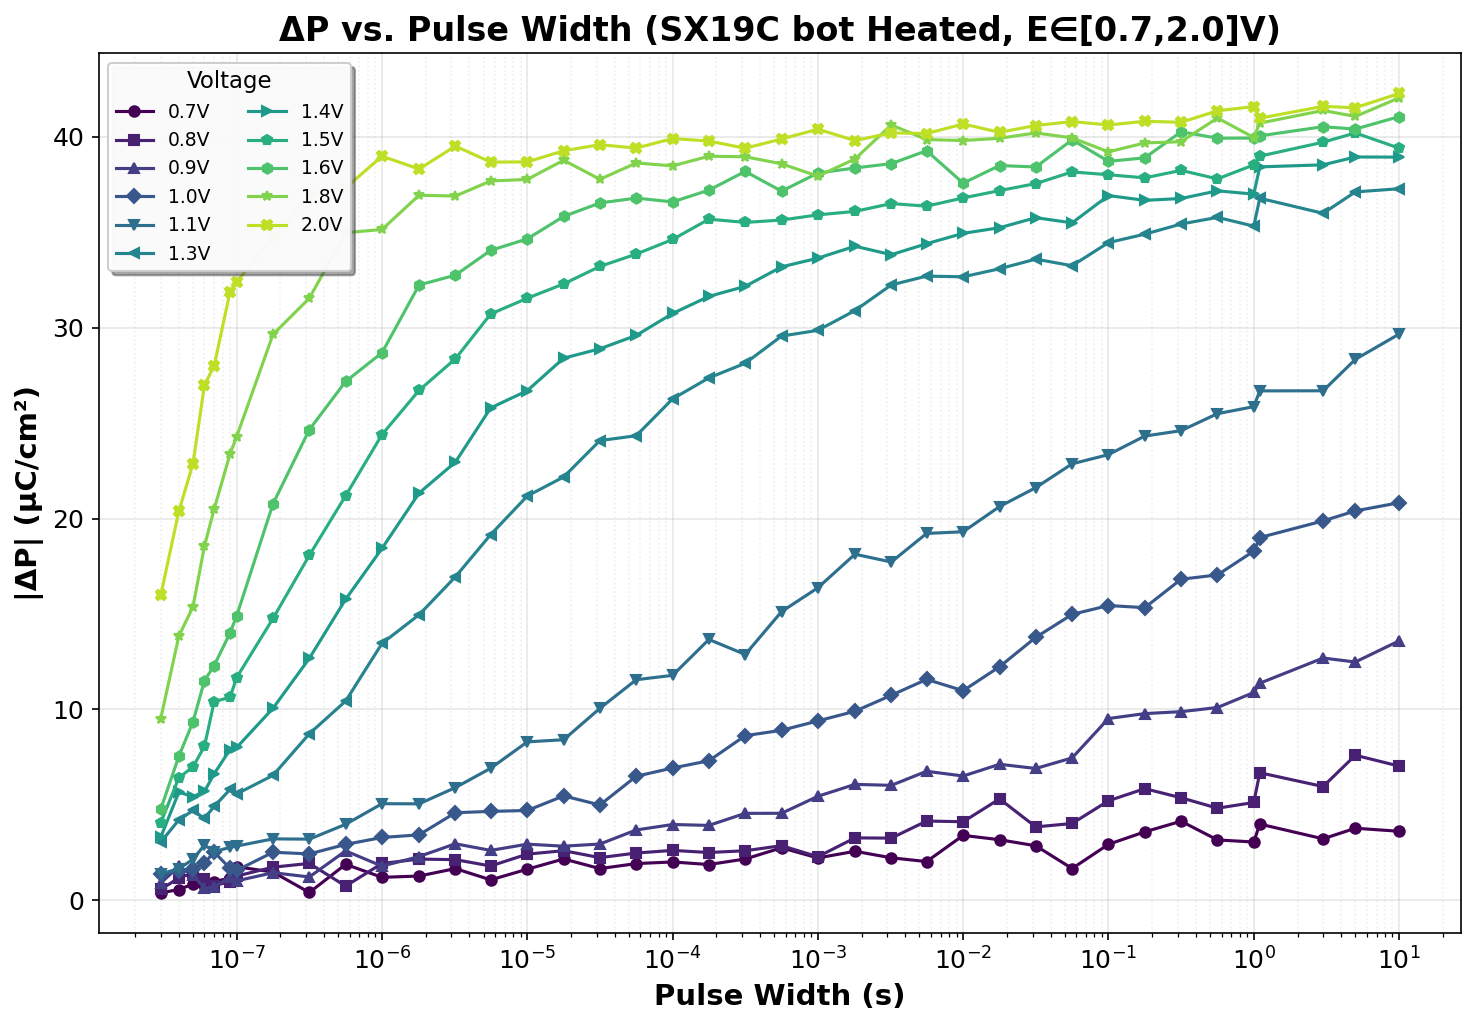

In [73]:
def plot_delta_p_vs_pulse_width(df, voltage_col='applied_E',
                                 use_log_x=True, use_abs_delta_p=True,
                                 figsize=(10, 7), title=None):
    """
    plot ΔP vs. Pulse Width 
    
    data structure:
    - first column (voltage_col): voltage condition, e.g. '0.5V', '0.6V', ...
    - other column names: pulse width values (seconds)
    - cell values: delta P
    """
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['font.size'] = 12
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # extract pulse width (column names, excluding the first column voltage)
    pulse_width_cols = [col for col in df.columns if col != voltage_col]
    pulse_widths = np.array([float(pw) for pw in pulse_width_cols])
    
    # index of sorted pulse width
    sort_idx = np.argsort(pulse_widths)
    pulse_widths_sorted = pulse_widths[sort_idx]
    
    # get all voltage conditions (skip rows with all NaN)
    n_voltages = len(df)
    colors = plt.cm.viridis(np.linspace(0, 0.9, n_voltages))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', 'h', '*', 'X', 'P']
    
    plot_count = 0
    for row_idx in range(n_voltages):
        voltage_label = str(df.iloc[row_idx][voltage_col])
        delta_p_values = df.iloc[row_idx][pulse_width_cols].values.astype(float)

        delta_p_sorted = delta_p_values[sort_idx]
        
        # skip rows with all NaN
        if np.all(np.isnan(delta_p_sorted)):
            continue
        
        # filter out NaN data points
        valid_mask = ~np.isnan(delta_p_sorted)
        x = pulse_widths_sorted[valid_mask]
        y = delta_p_sorted[valid_mask]
        
        if use_abs_delta_p:
            y = np.abs(y)
        
        marker = markers[plot_count % len(markers)]
        color = colors[row_idx]
        
        if use_log_x:
            ax.semilogx(x, y,
                        marker=marker, markersize=5,
                        color=color, linewidth=1.5,
                        label=voltage_label)
        else:
            ax.plot(x, y,
                    marker=marker, markersize=5,
                    color=color, linewidth=1.5,
                    label=voltage_label)
        plot_count += 1
    
    ax.set_xlabel('Pulse Width (s)', fontsize=14, fontweight='bold')
    ax.set_ylabel('|ΔP| (μC/cm²)', fontsize=14, fontweight='bold')
    
    if title is None:
        title = 'ΔP vs. Pulse Width for Different Voltage Conditions'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    ax.grid(True, which='major', linestyle='-', alpha=0.3)
    ax.grid(True, which='minor', linestyle=':', alpha=0.2)
    
    ax.legend(fontsize=9, framealpha=0.95, fancybox=True, shadow=True,
              title='Voltage', title_fontsize=11,
              loc='best', ncol=2)
    
    plt.tight_layout()
    plt.show()
    return fig


fig = plot_delta_p_vs_pulse_width(
    df_range,
    voltage_col=VOLTAGE_COL,
    use_log_x=True,
    use_abs_delta_p=True,
    title=f'ΔP vs. Pulse Width (SX19C bot Heated, E∈[{E_MIN},{E_MAX}]V)'
)

In [74]:
# %%
# 计算每个 pulse_width 下的  E_applied * (dP/dE) / (2Pr)
# - deltaP 来自第 1 个 sheet（df）
# - Pr 来自第 2 个 sheet（df_Pr）
# 仅保留 pulse_width = 10^n (n 为整数) 的列；每个差分点归属到 lower 的 E

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

voltage_col = VOLTAGE_COL  # 'applied_E'

# 使用限定范围后的数据
df_use = df_range
df_Pr_use = df_Pr_range

if df_Pr_use is None:
    raise ValueError('未加载 Pr（df_Pr=None）。请使用包含第二个 sheet(Pr) 的 xlsx 文件。')

# --- 1) 解析 E 列为数值（兼容 '2.3V' 这种格式） ---
E_series = df_use[voltage_col].astype(str).str.strip().str.replace('V', '', regex=False)
E_all = pd.to_numeric(E_series, errors='coerce').to_numpy()

# --- 2) 找出所有 pulse_width 列，并筛选出 10^n 秒 ---
pulse_cols = [c for c in df.columns if c != voltage_col]

col_pw = []  # (column_name, pulse_width_float)
for c in pulse_cols:
    try:
        pw = float(c)
        if pw > 0:
            col_pw.append((c, pw))
    except Exception:
        # 跳过无法转换为数值的列名
        pass

col_pw_df = pd.DataFrame(col_pw, columns=['col', 'pulse_width'])

if col_pw_df.empty:
    raise ValueError('未找到可解析为数值的 pulse_width 列（除 applied_E 外的列名应为秒数）。')

pw = col_pw_df['pulse_width'].to_numpy(dtype=float)
exp = np.round(np.log10(pw))
pw_pow = np.power(10.0, exp)
mask_pow10 = np.isclose(pw, pw_pow, rtol=1e-6, atol=0)

col_pw_df = col_pw_df.loc[mask_pow10].copy()
col_pw_df['pulse_width'] = pw_pow[mask_pow10]  # 归一化到精确的 10^n
col_pw_df = col_pw_df.sort_values('pulse_width')

# --- 3) 对每个 pulse_width 列：沿 E 方向做差分得到 dP/dE，并计算指标 ---
metric_rows = []

for _, r in col_pw_df.iterrows():
    col = r['col']
    pw_val = float(r['pulse_width'])

    if col not in df_Pr.columns:
        # Pr sheet 缺列就跳过
        continue

    # deltaP 与 Pr：两张表按相同 index/列对齐
    dP_all = pd.to_numeric(df_use[col], errors='coerce').to_numpy()
    Pr_all = pd.to_numeric(df_Pr_use[col], errors='coerce').to_numpy()

    # 只保留 E / deltaP / Pr 同时有效的数据点，并按 E 升序排序
    valid = np.isfinite(E_all) & np.isfinite(dP_all) & np.isfinite(Pr_all)
    E = E_all[valid]
    dP_vals = -dP_all[valid]
    Pr = Pr_all[valid]

    if E.size < 2:
        continue

    order = np.argsort(E)
    E = E[order]
    dP_vals = dP_vals[order]
    Pr = Pr[order]

    dE = np.diff(E)
    dP = np.diff(dP_vals)

    E_low = E[:-1]        # lower E
    Pr_low = Pr[:-1]      # 与 lower E 对应的 Pr

    with np.errstate(divide='ignore', invalid='ignore'):
        dP_dE = dP / dE
        metric = E * dP_dE / (2.0 * Pr_low)

    keep = np.isfinite(metric) & np.isfinite(E_low) & (dE != 0) & (Pr_low != 0)

    for e, m in zip(E_low[keep], metric[keep]):
        metric_rows.append({
            'pulse_width': pw_val,
            'E_lower': float(e),
            'metric': float(m),
        })

metric_df = pd.DataFrame(metric_rows)

if metric_df.empty:
    raise ValueError('计算结果为空：请检查 applied_E 是否可解析、以及各 pulse 列是否有足够的非空数据点。')

metric_df['E_lower_round'] = metric_df['E_lower'].round(6)
metric_df = metric_df.sort_values(['E_lower_round', 'pulse_width'])

metric_df.head(10)

# --- 4) 画图：x = pulse_width(对数)，y = 指标；按 lower E 分类 ---
# --- 4) 画图：x = E_lower，y = 指标；按 pulse_width 分类 ---
fig, ax = plt.subplots(figsize=(10, 6))

# 确保 E 顺序正确（而且每条曲线按 E 排序画）
for pw_val in sorted(metric_df['pulse_width'].unique()):
    sub = metric_df.loc[metric_df['pulse_width'] == pw_val].sort_values('E_lower')
    ax.plot(sub['E_lower'], sub['metric'], marker='o', linewidth=1.5, label=f"pw={pw_val:g}s")

ax.set_xlabel('E (V) [lower E]')
ax.set_ylabel('E * (dP/dE) / (2Pr)')
ax.set_title(f'E * (dP/dE) / (2Pr) vs E, E∈[{E_MIN},{E_MAX}]V')

# x 轴是否要 log：通常 E 不用 log；如果你想用 logE，把下一行取消注释
# ax.set_xscale('log')

ax.grid(True, which='both', linestyle=':', alpha=0.3)

ax.legend(title='pulse_width', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()



ValueError: operands could not be broadcast together with shapes (11,) (10,) 

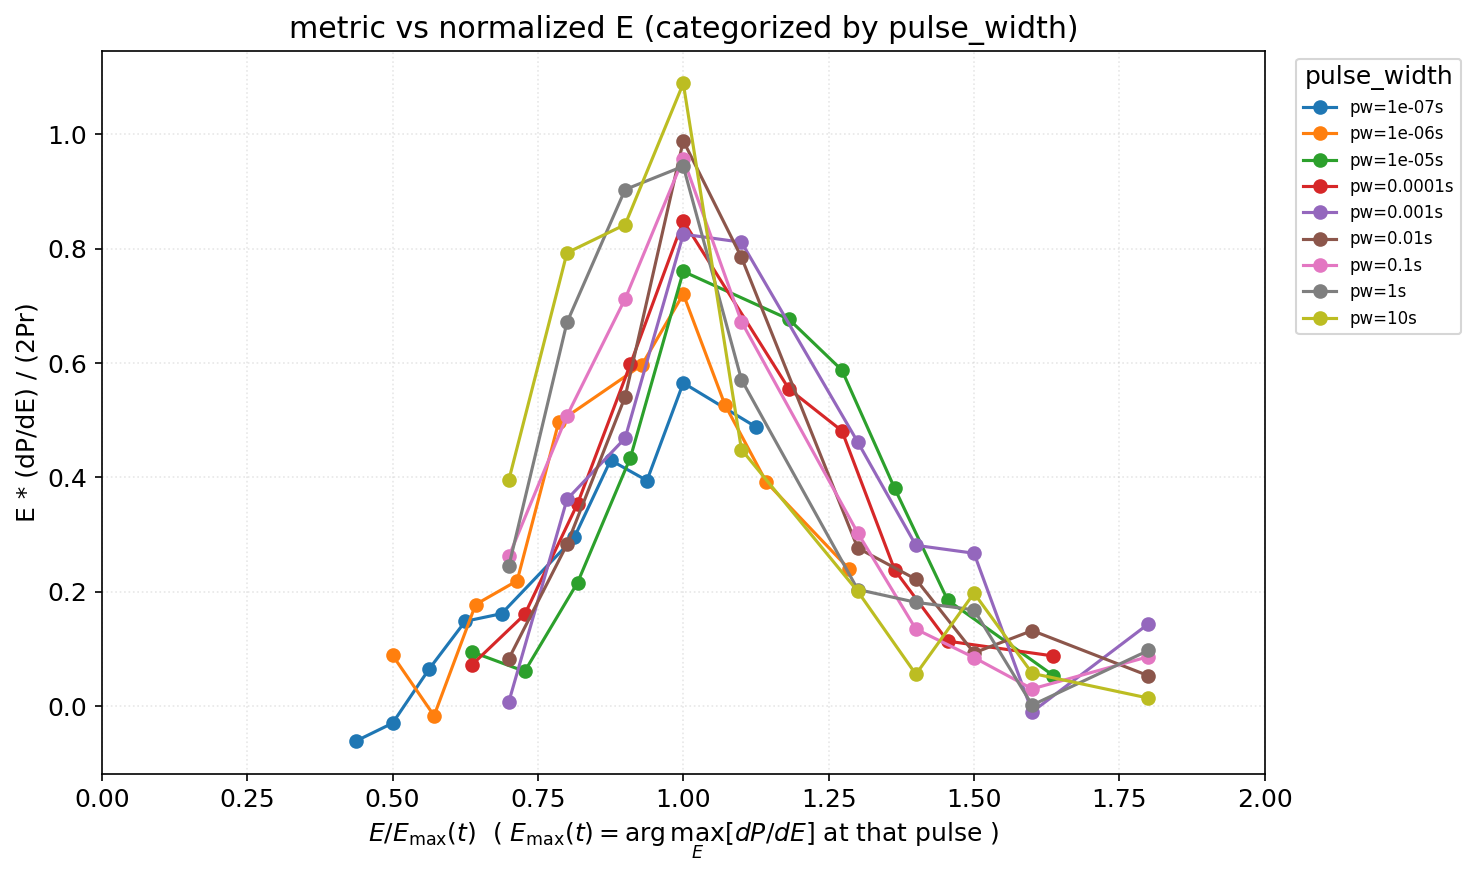

In [ ]:
# ============================================================
# EXTRA BLOCK (no change to your original pipeline):
# Define Emax(t) for each pulse_width as the E-position where (dP/dE) is maximal,
# then normalize x-axis to E/Emax(t) and plot metric vs normalized E.
#
# Assumptions:
# - You have already run your original code and obtained `metric_df`
#   with columns: ['pulse_width', 'E_lower', 'metric'].
# - `df_range` (df_use), `df_Pr_range` (df_Pr_use), `voltage_col`,
#   and your original pulse-width filtering logic are already available.
# - "每个差分点归属到 lower 的 E" => E-position for derivative is E_low.
# ============================================================

# --- 0) sanity check ---
needed_cols = {'pulse_width', 'E_lower', 'metric'}
if metric_df is None or metric_df.empty or not needed_cols.issubset(metric_df.columns):
    raise ValueError(f"metric_df 不存在/为空/缺列。需要列: {needed_cols}, 现有列: {set(metric_df.columns) if metric_df is not None else None}")

# --- 1) Recompute Emax(t) for each pulse_width (argmax_E dP/dE at that pulse) ---
#     We do NOT touch your metric computation; we only compute Emax(t) separately and merge.
Emax_rows = []

# (a) parse full E array from df_use (same as your original parsing)
E_series_full = df_use[voltage_col].astype(str).str.strip().str.replace('V', '', regex=False)
E_all_full = pd.to_numeric(E_series_full, errors='coerce').to_numpy()

# (b) use the SAME pulse columns selection as your original code did:
#     - pulse widths from sheet1 columns except voltage_col
#     - keep only pulse_width = 10^n (n integer)
pulse_cols_full = [c for c in df.columns if c != voltage_col]

col_pw = []
for c in pulse_cols_full:
    try:
        pw = float(c)
        if pw > 0:
            col_pw.append((c, pw))
    except Exception:
        pass

col_pw_df = pd.DataFrame(col_pw, columns=['col', 'pulse_width'])
if col_pw_df.empty:
    raise ValueError('未找到可解析为数值的 pulse_width 列（除 applied_E 外的列名应为秒数）。')

pw = col_pw_df['pulse_width'].to_numpy(dtype=float)
exp = np.round(np.log10(pw))
pw_pow = np.power(10.0, exp)
mask_pow10 = np.isclose(pw, pw_pow, rtol=1e-6, atol=0)

col_pw_df = col_pw_df.loc[mask_pow10].copy()
col_pw_df['pulse_width'] = pw_pow[mask_pow10]
col_pw_df = col_pw_df.sort_values('pulse_width')

# (c) compute Emax(t) per pulse: E_low at which dP/dE is maximum
for _, r in col_pw_df.iterrows():
    col = r['col']
    pw_val = float(r['pulse_width'])

    # require both deltaP and Pr columns exist
    if col not in df_use.columns:
        continue
    if col not in df_Pr_use.columns:
        continue

    dP_all = pd.to_numeric(df_use[col], errors='coerce').to_numpy()
    Pr_all = pd.to_numeric(df_Pr_use[col], errors='coerce').to_numpy()

    valid = np.isfinite(E_all_full) & np.isfinite(dP_all) & np.isfinite(Pr_all)
    E = E_all_full[valid]
    dP_vals = -dP_all[valid]  # keep consistent with your original sign
    Pr = Pr_all[valid]

    if E.size < 2:
        continue

    order = np.argsort(E)
    E = E[order]
    dP_vals = dP_vals[order]
    Pr = Pr[order]

    dE = np.diff(E)
    dP = np.diff(dP_vals)
    E_low = E[:-1]

    with np.errstate(divide='ignore', invalid='ignore'):
        dP_dE = dP / dE

    keep_deriv = np.isfinite(dP_dE) & np.isfinite(E_low) & (dE != 0)
    if not np.any(keep_deriv):
        continue

    # Emax(t) = position of maximum of derivative at time t (pulse_width)
    # If you instead want max magnitude peak, use: np.nanargmax(np.abs(dP_dE[keep_deriv]))
    idx = np.nanargmax(dP_dE[keep_deriv])
    Emax_t = float(E_low[keep_deriv][idx])

    Emax_rows.append({'pulse_width': pw_val, 'Emax_t': Emax_t})

Emax_df = pd.DataFrame(Emax_rows).drop_duplicates(subset=['pulse_width'])
if Emax_df.empty:
    raise ValueError("无法计算任何 pulse 的 Emax(t)：请检查数据是否足够、以及各列是否存在/有效。")

# --- 2) merge Emax(t) into existing metric_df and build normalized x = E/Emax(t) ---
metric_df_norm = metric_df.merge(Emax_df, on='pulse_width', how='left')

# drop rows without Emax_t (e.g., if some pulse in metric_df wasn't in Emax_df)
metric_df_norm = metric_df_norm[np.isfinite(metric_df_norm['Emax_t']) & (metric_df_norm['Emax_t'] != 0)]
metric_df_norm['E_norm'] = metric_df_norm['E_lower'] / metric_df_norm['Emax_t']

# --- 3) plot metric vs normalized E, categorized by pulse_width ---
fig, ax = plt.subplots(figsize=(10, 6))

for pw_val in sorted(metric_df_norm['pulse_width'].unique()):
    sub = metric_df_norm.loc[metric_df_norm['pulse_width'] == pw_val].sort_values('E_norm')
    ax.plot(sub['E_norm'], sub['metric'], marker='o', linewidth=1.5, label=f"pw={pw_val:g}s")

ax.set_xlabel(r'$E/E_{\max}(t)$  ( $E_{\max}(t)=\arg\max_E[dP/dE]$ at that pulse )')
ax.set_ylabel('E * (dP/dE) / (2Pr)')
ax.set_title('metric vs normalized E (categorized by pulse_width)')
ax.grid(True, which='both', linestyle=':', alpha=0.3)
ax.set_xlim(0, 2)

ax.legend(title='pulse_width', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()
